In [43]:
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq,Linear,ReLU,BatchNorm1d
from torch_scatter import scatter_mean
import yaml
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from GraphDataset import GraphDataset

from InteractionNetwork import InteractionNetwork

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_style("white")

In [9]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from mpl_toolkits.mplot3d.axes3d import Axes3D
import networkx as nx
import matplotlib.colors as colors
from torch_geometric.utils import to_networkx

In [62]:
relevance_collection=[torch.load(f"../data/file_{i}_relevance.pt") for i in range(10)]

In [45]:
# get data

import yaml
from GraphDataset import GraphDataset


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



with open('../data/definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']


file_names=["/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_0.root"]
graph_dataset = GraphDataset('../data', features, labels, spectators, n_events=10000, n_events_merge=1000, 
                             file_names=file_names)

batch=graph_dataset[0]

In [27]:
relevance=relevance_collection[0]
relevance[0].keys()

dict_keys(['node', 'edge', 'label', 'pred'])

In [37]:
# load feature definitions
with open('../data/definitions.yml') as file:
    definitions = yaml.load(file, Loader=yaml.FullLoader)

features = definitions['features']

In [202]:
def network_plot_3D(G, angle,label, edge_alpha,title_str,zlabel="track_pt",threshold=0.5,save=False):

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    node_shade=nx.get_node_attributes(G,"node_shade")
    
    # Get number of nodes
    n = G.number_of_nodes()

    # 3D network plot
    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(10,7))
        ax = Axes3D(fig,)
        ax.w_xaxis.set_pane_color((0.94,0.94,0.94,1))
        ax.w_yaxis.set_pane_color((0.90,0.90,0.90,1))
        ax.w_zaxis.set_pane_color((0.92,0.92,0.92,1))
        
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            
            # Scatter plot
            ax.scatter(xi, yi, zi, c='k',s=node_shade[key], edgecolors='orange', alpha=0.5)
        

        for i,j in enumerate(G.edges()):

            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
            
            alpha=edge_alpha[i]
            if alpha<threshold:
                ax.plot(x, y, z, c='#546163', alpha=0.03)
            else:
                ax.plot(x, y, z, c='r', alpha=alpha,linewidth=2)
    
    # Set the initial view
    ax.view_init(30, angle)
    ax.set_facecolor("white")

    plt.xlabel("track_etarel")
    plt.ylabel("track_phirel")
    ax.set_zlabel(zlabel)
    
    plt.title(title_str)
    plt.show()

In [207]:
def plot_edge3d(R,ix,raw_input,features,x,y,z):
    r_node=R['node'].clone()
    r_edge=R['edge'].clone()
    r_node[torch.isnan(r_node)]=0
    r_edge[torch.isnan(r_edge)]=0

    edge_shade=torch.norm(r_edge,dim=1)
    edge_alpha=(edge_shade-edge_shade.min())/edge_shade.max()
    edge_alpha=edge_alpha.detach().cpu().numpy()

    node_shade=np.linalg.norm(r_node.detach().cpu().numpy(),axis=1)
    
    x_idx=features.index(x)
    y_idx=features.index(y)
    z_idx=features.index(z)
    
    raw_input.edge_alpha=edge_alpha
    raw_input.node_shade=node_shade

    pos=np.array(list(zip(raw_input.x[:,x_idx].detach().numpy(),
                          raw_input.x[:,y_idx].detach().numpy(),
                          raw_input.x[:,z_idx].detach().numpy())))
    raw_input.pos=pos
    
    G = to_networkx(raw_input, node_attrs=["pos","node_shade"])
    if R['label'][:,1]>0:
        title_str="Edge and Node Relevance in 3d Space for Higgs boson Signal\n\n"
    else:
        title_str="Edge and Node Relevance in 3d Space for background\n\n"
    title_str+="prediction:{}".format(R["pred"].detach().cpu().numpy().round(4)[0])
    
    network_plot_3D(G,45,raw_input.y.detach(),edge_alpha,title_str,zlabel=z)

In [208]:
x="track_etarel"
y="track_phirel"
z="trackBTag_Sip3dVal"

batch 1, jet 702


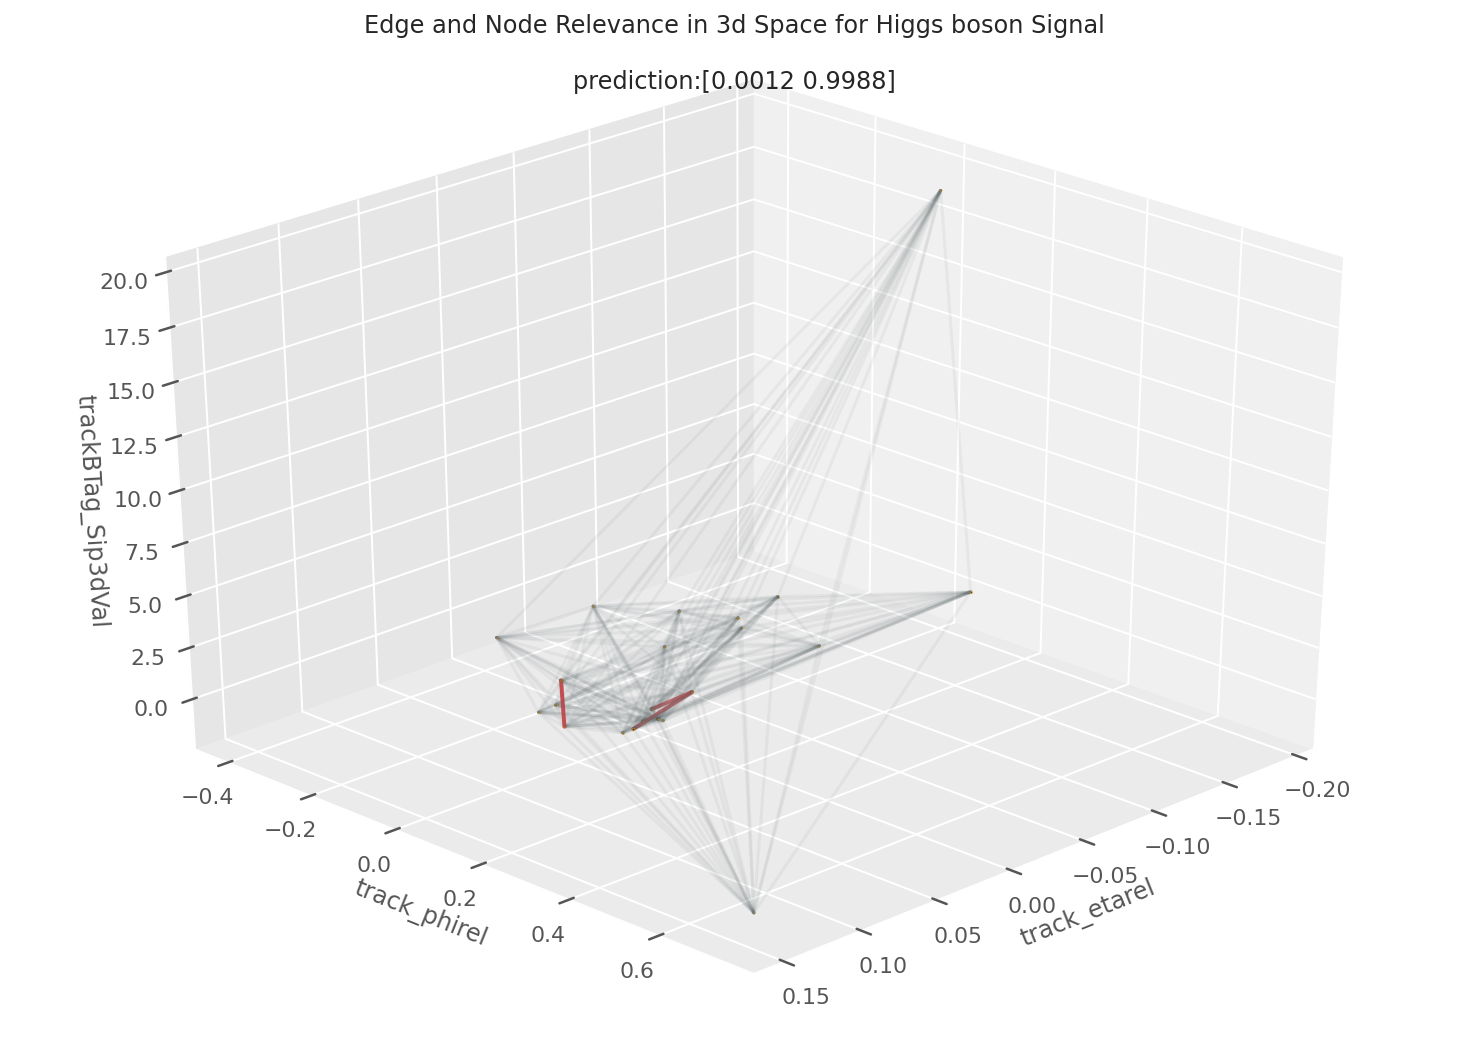

batch 2, jet 334


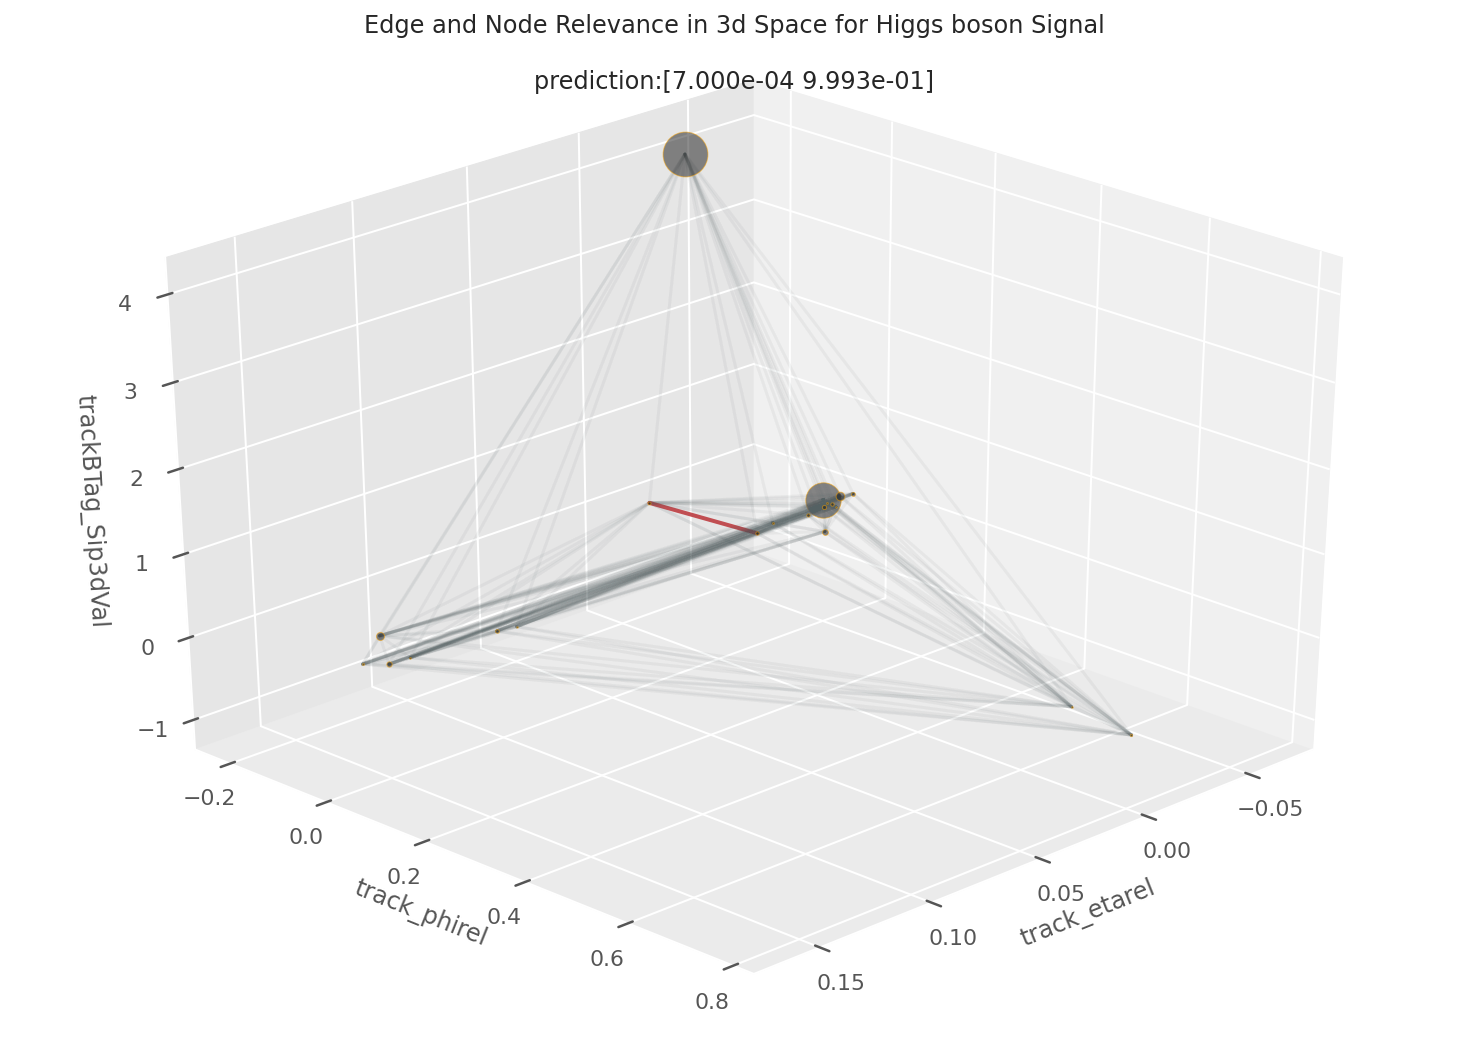

batch 3, jet 162


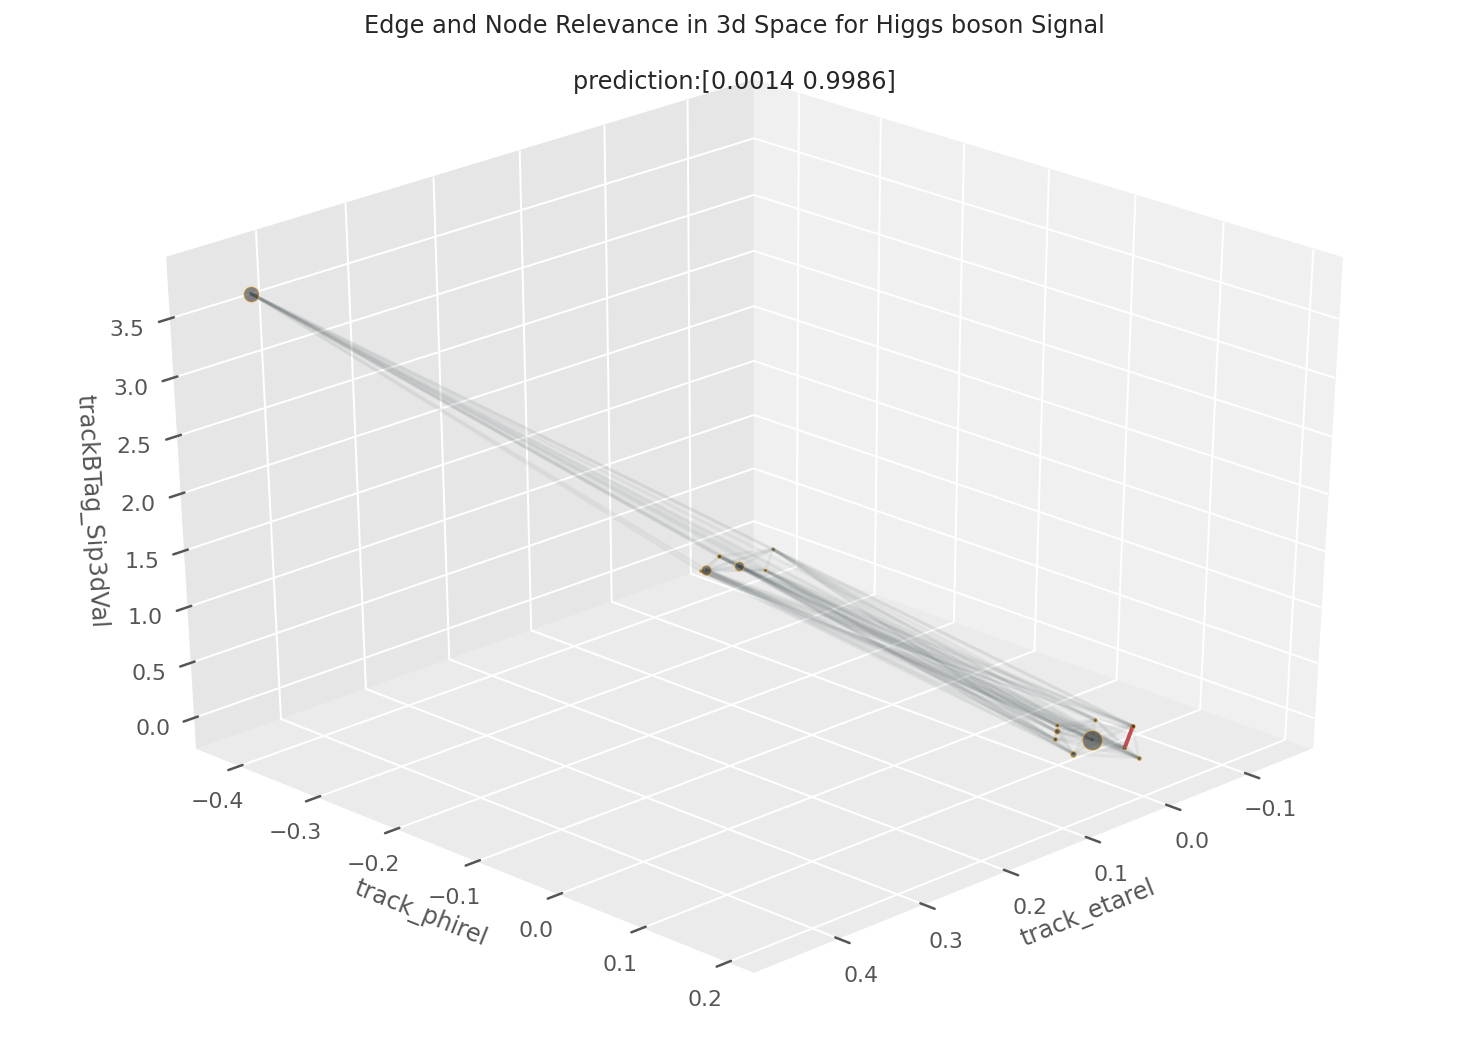

batch 3, jet 318


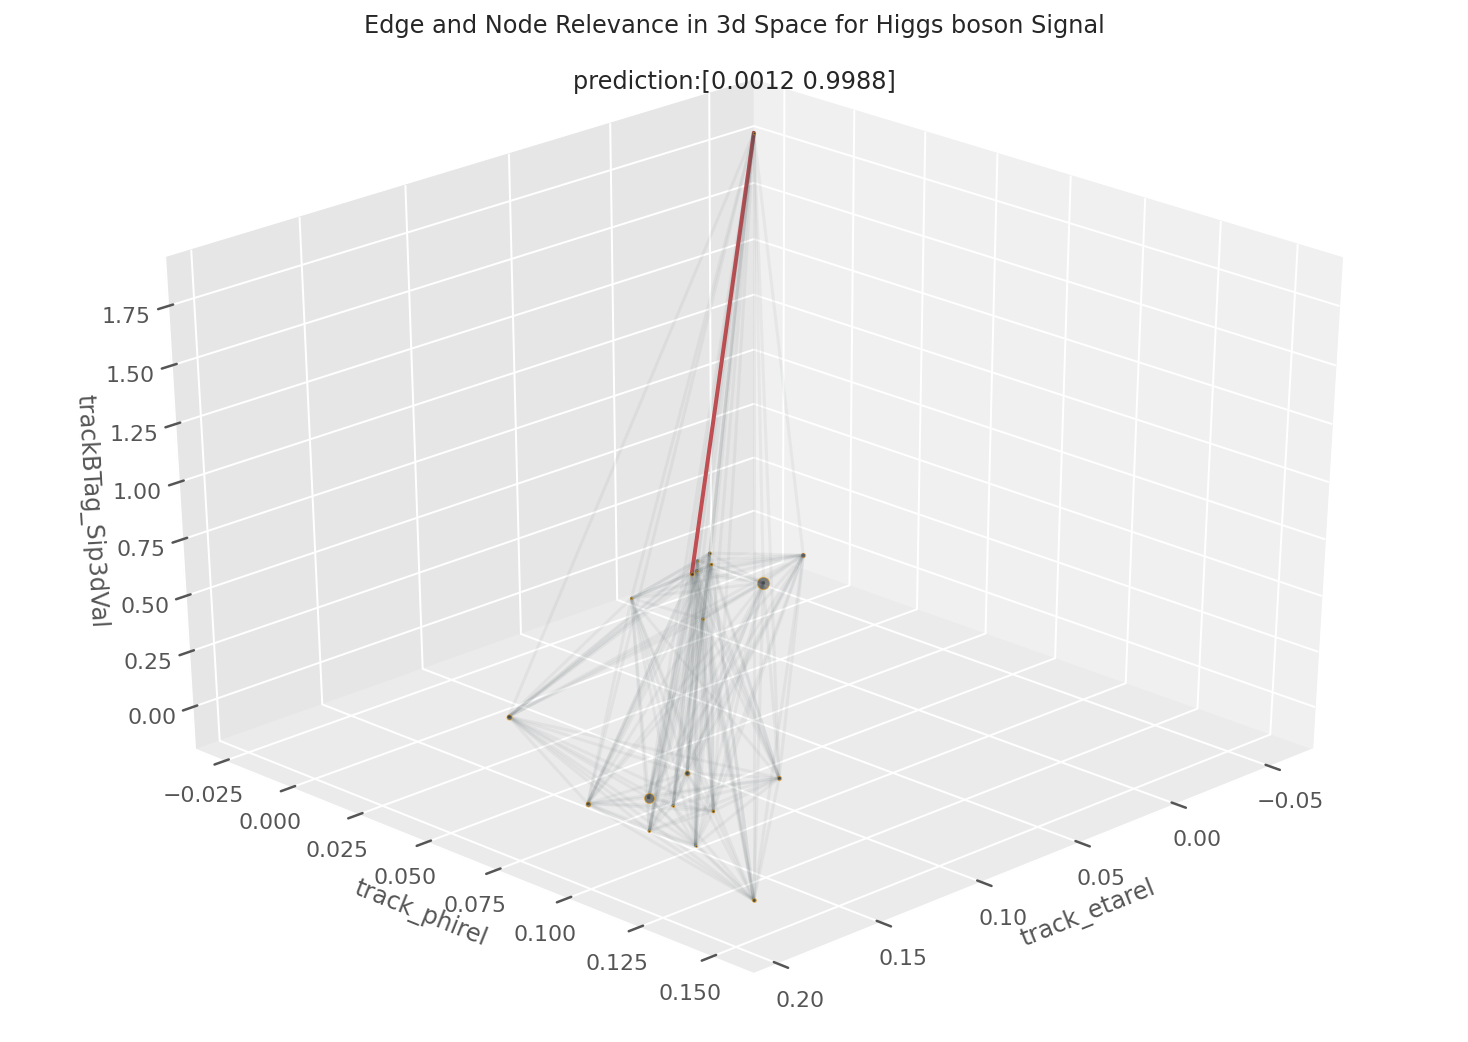

batch 3, jet 443


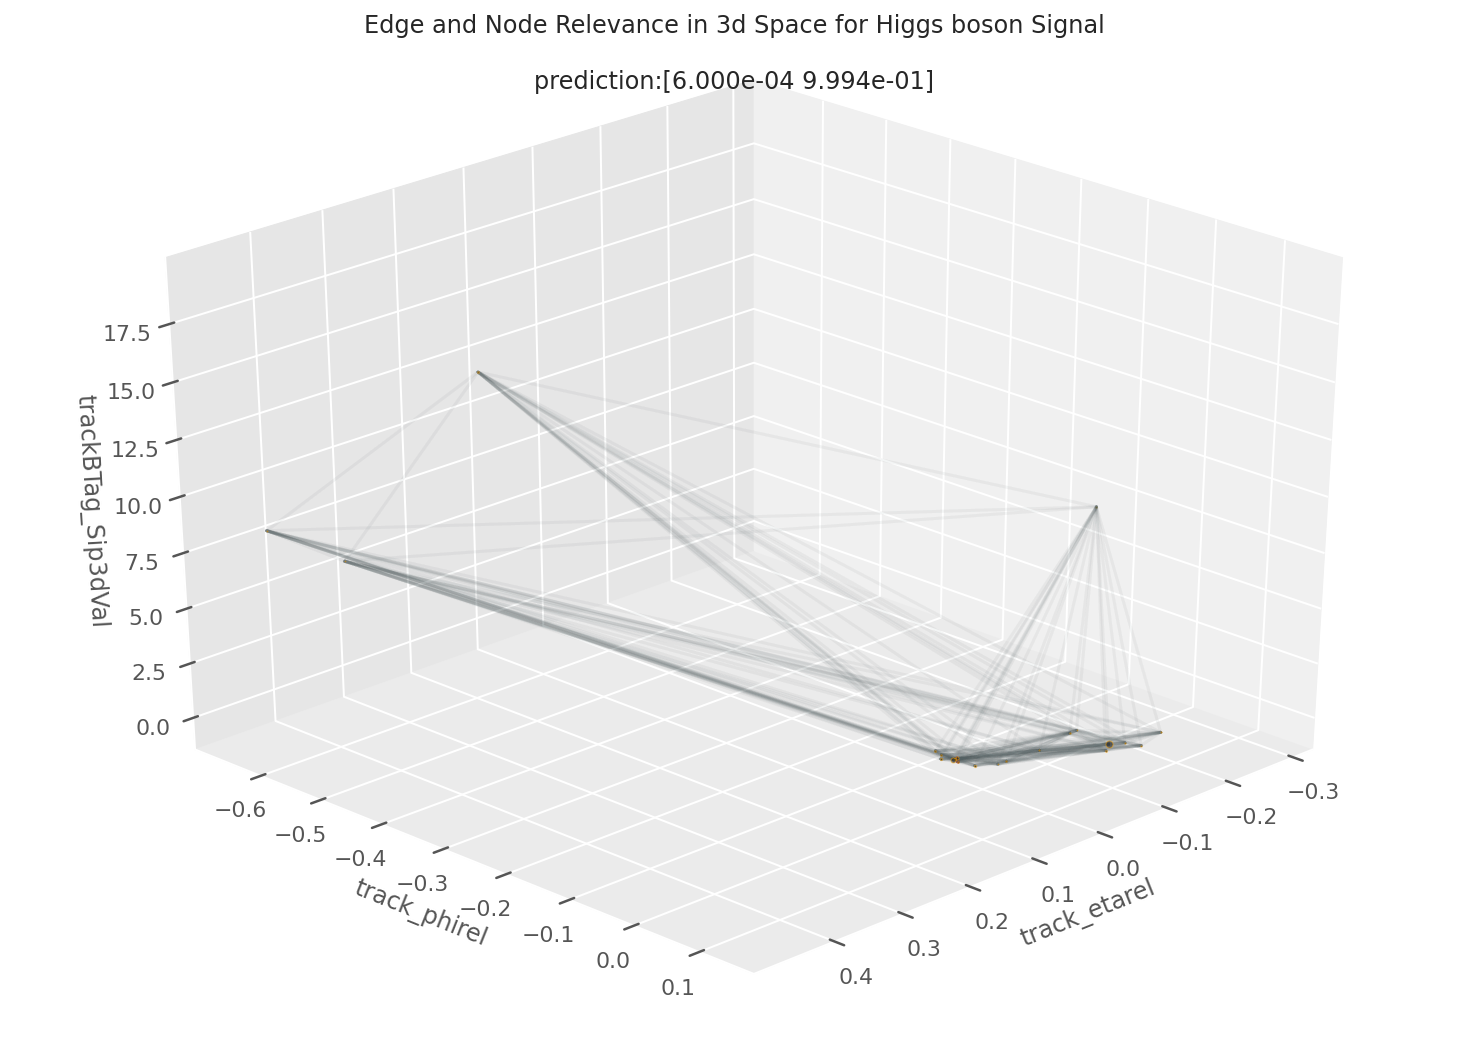

batch 3, jet 915


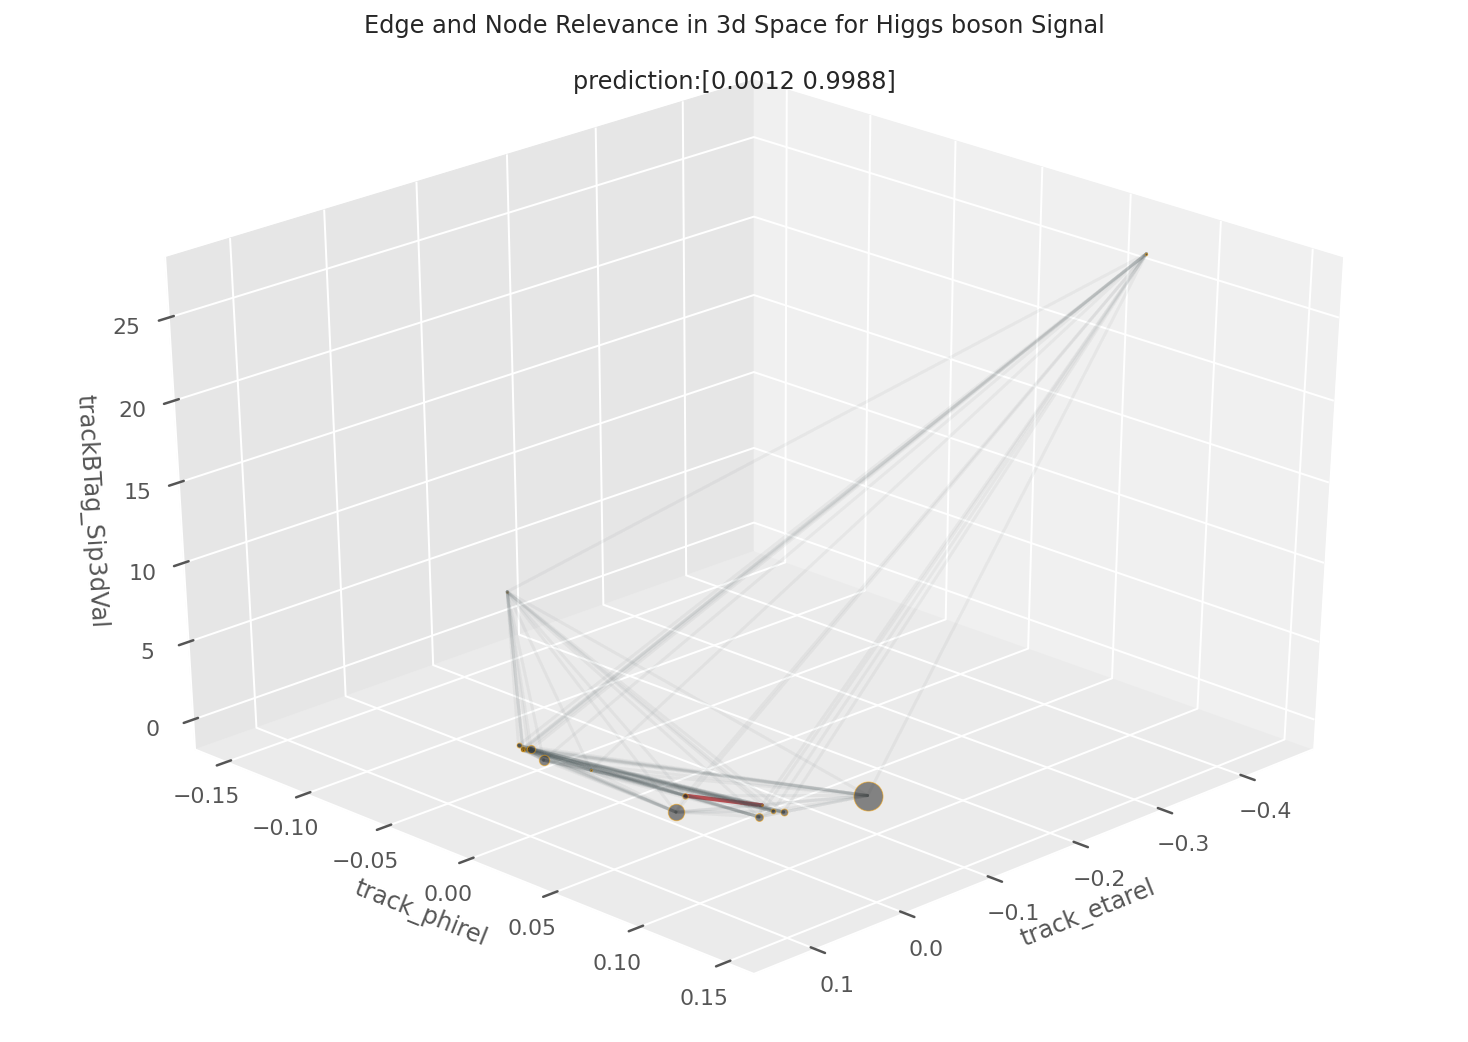

batch 4, jet 866


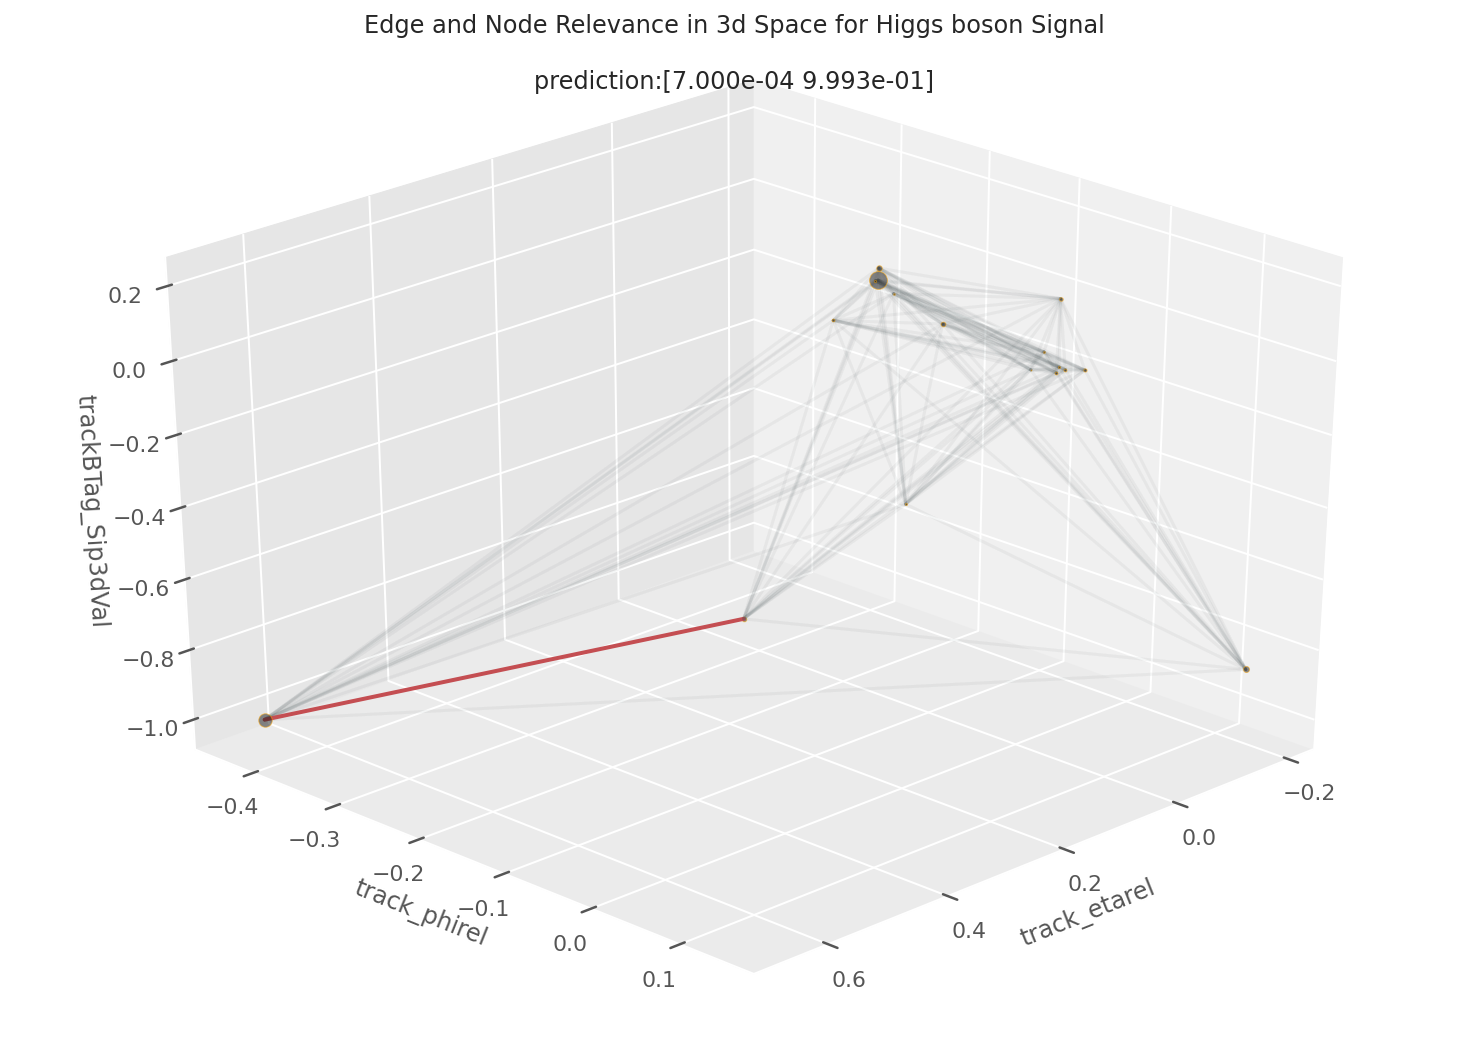

batch 5, jet 589


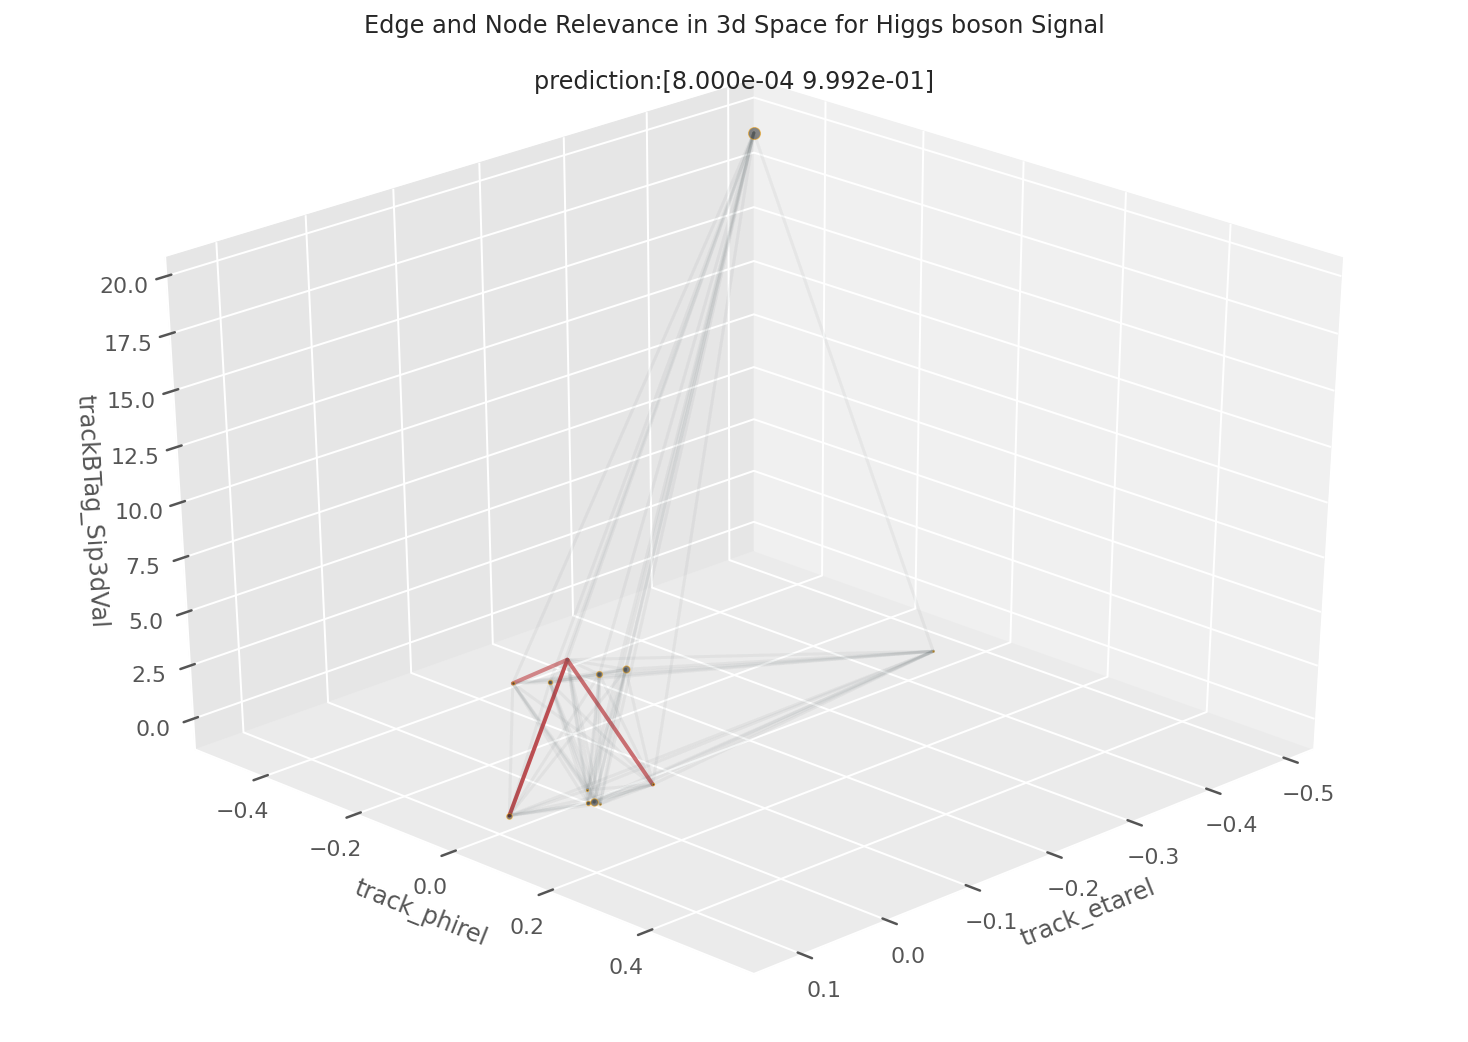

batch 6, jet 890


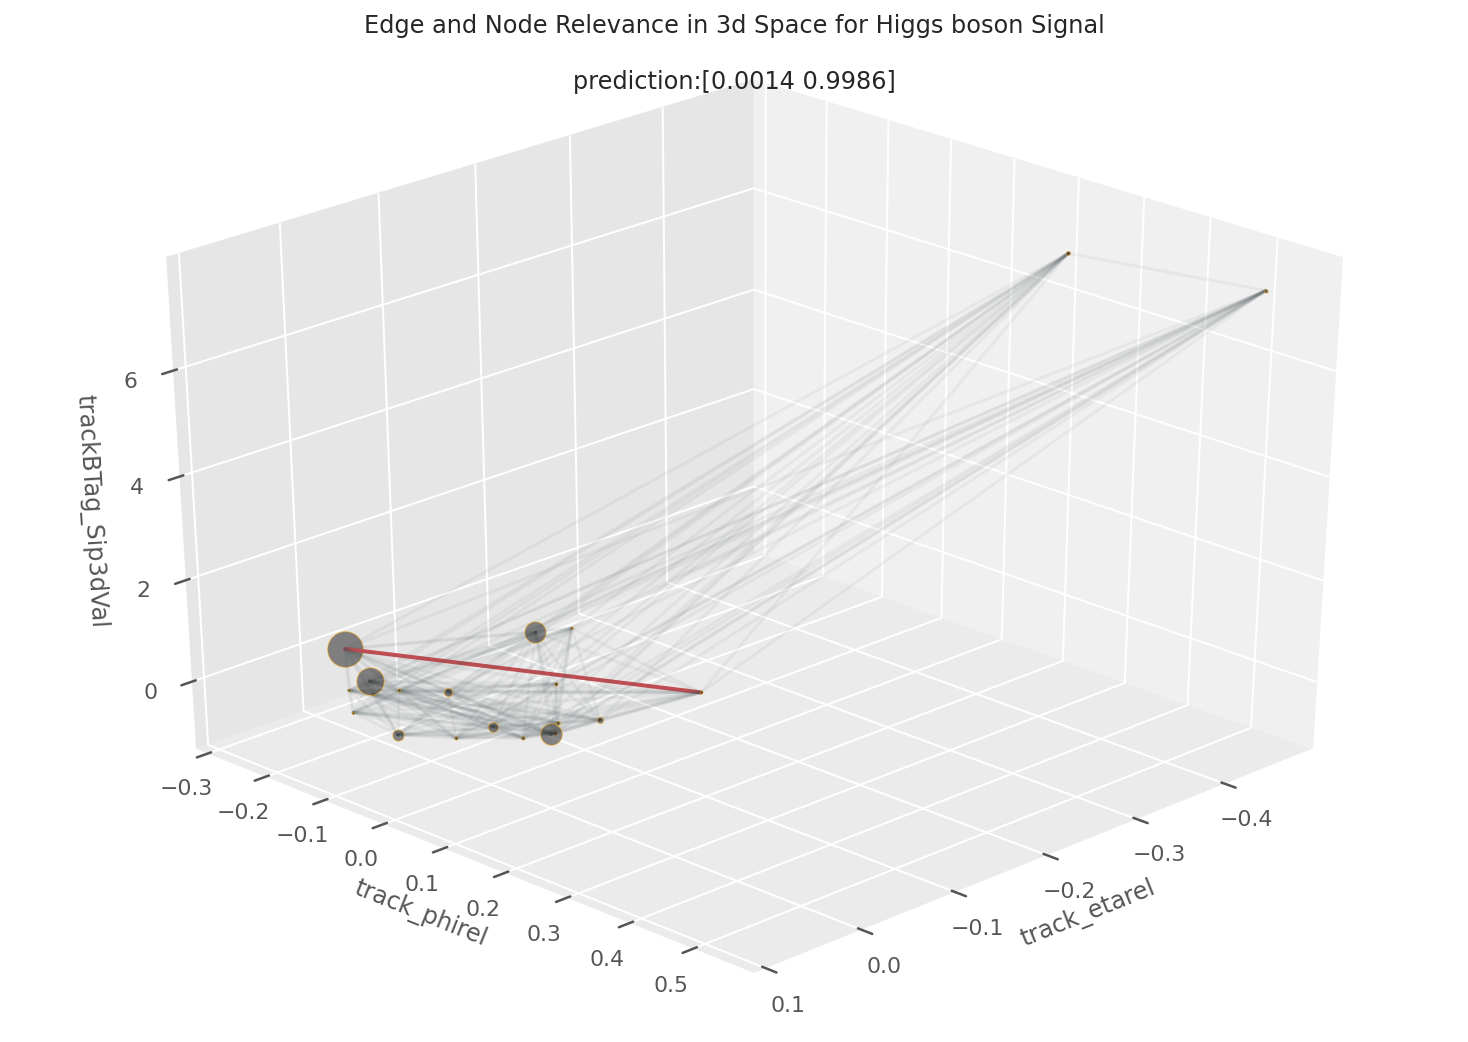

batch 9, jet 257


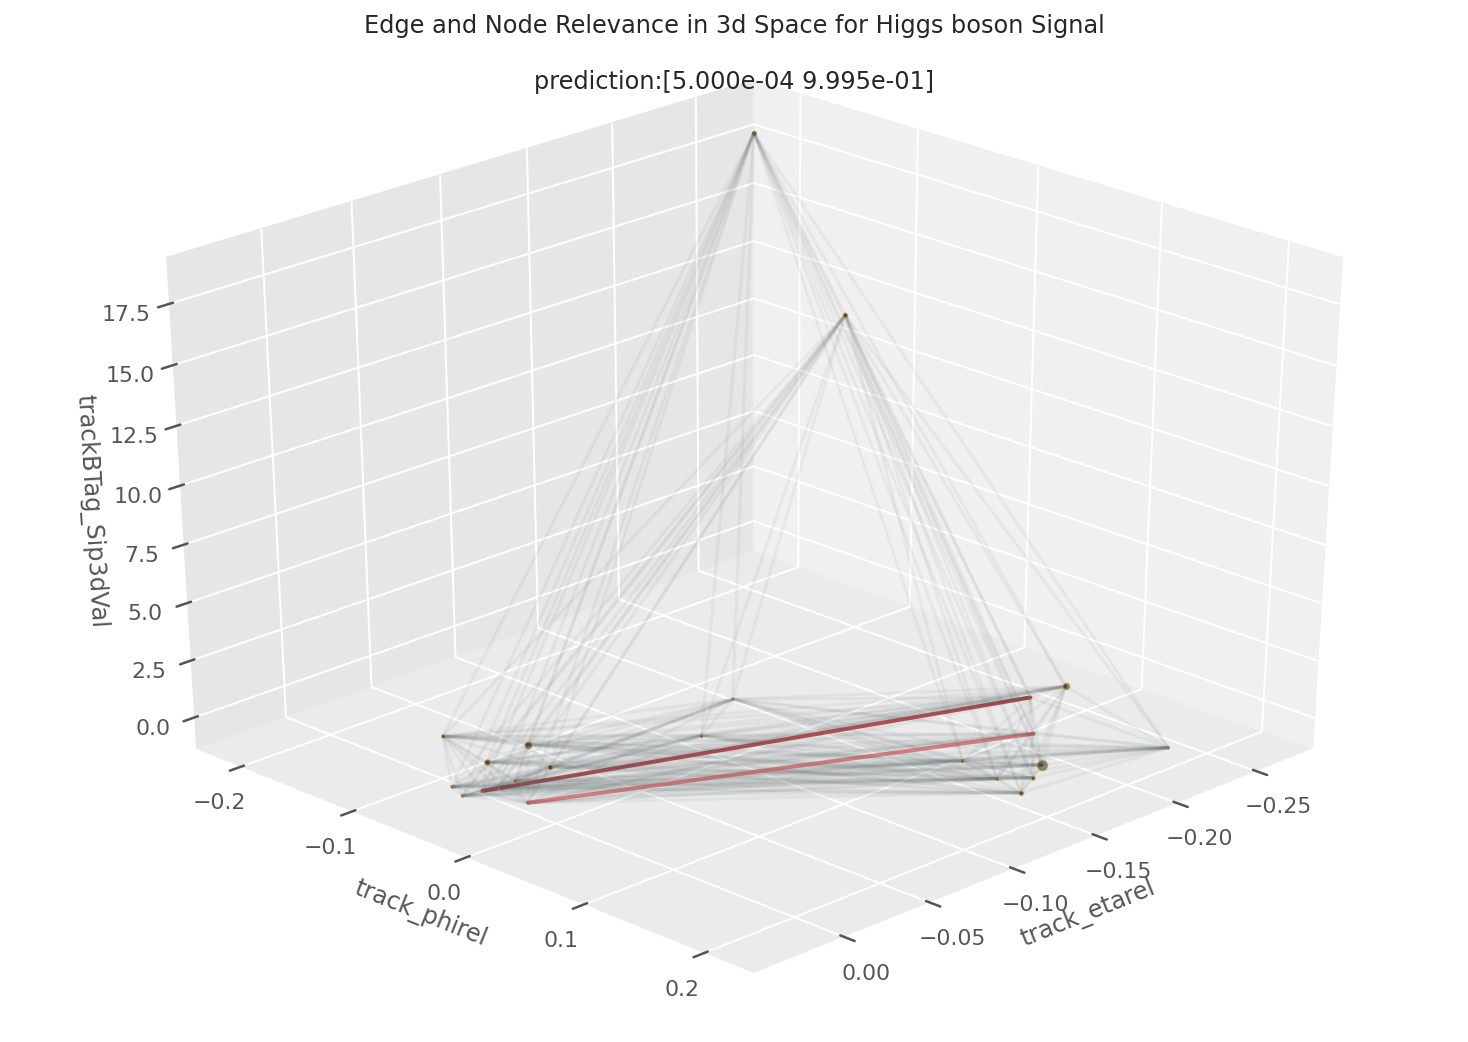

In [209]:
ix_list=[702,334,162,318,443,915,866,589,890,257]
bix_list=[1,2,3,3,3,3,4,5,6,9]

for ix,bix in zip(ix_list,bix_list):
    R=relevance_collection[bix][ix]
    raw_input=graph_dataset[bix][ix]
    
    print(f"batch {bix}, jet {ix}")
    plot_edge3d(R,ix,raw_input,features,x,y,z)

batch 1, jet 702


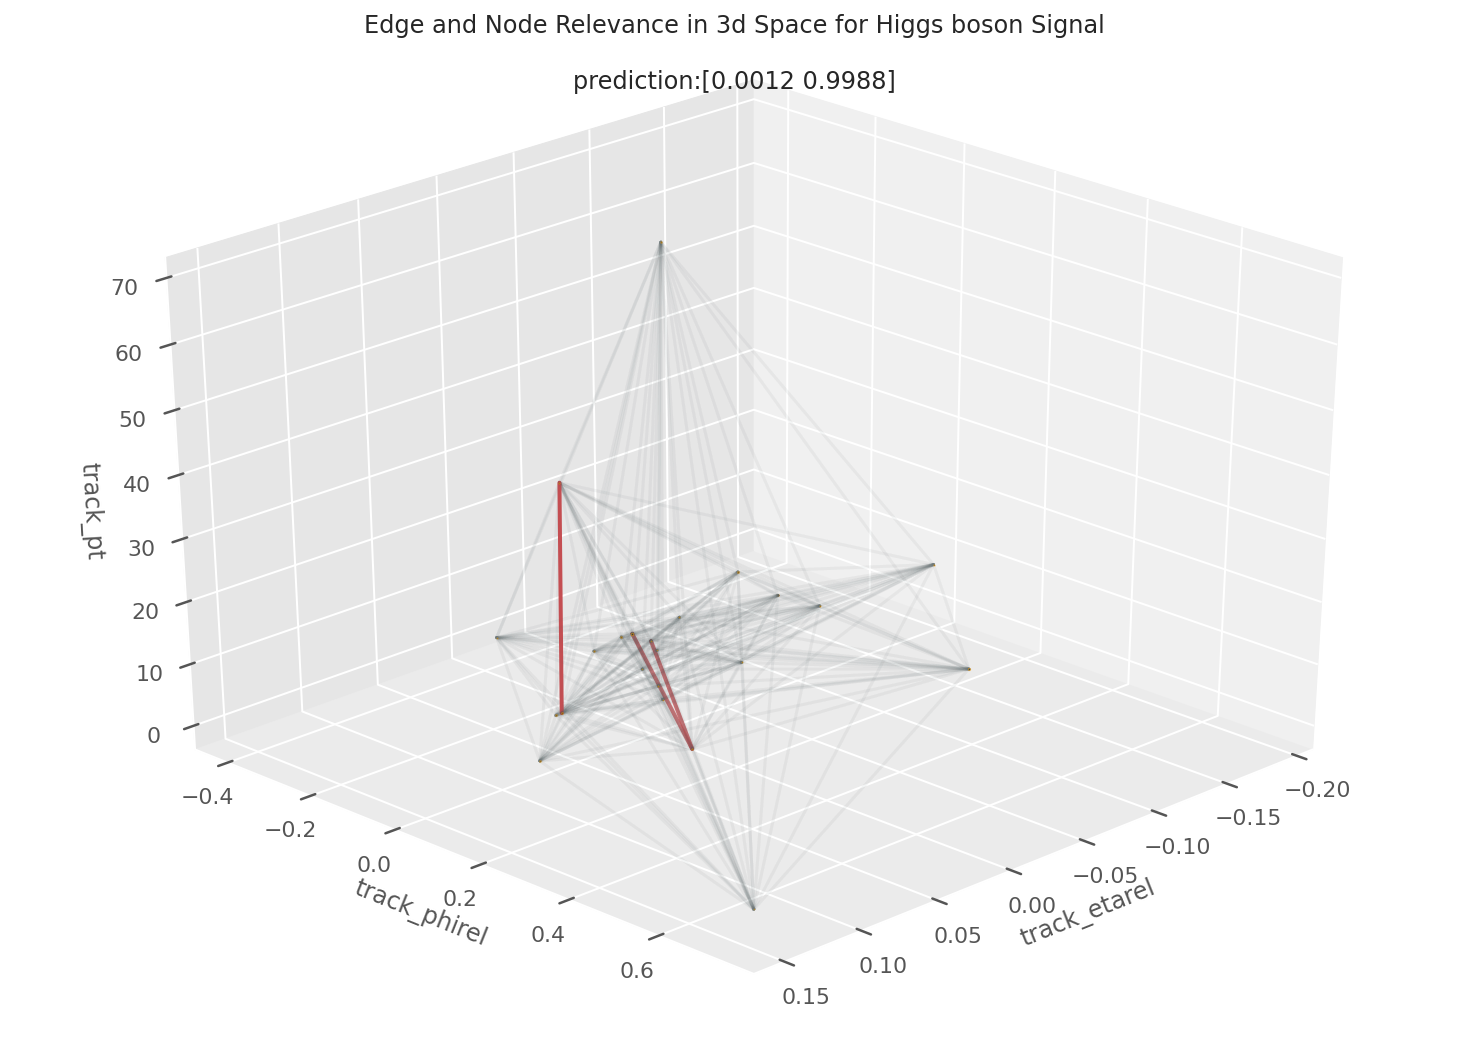

batch 2, jet 334


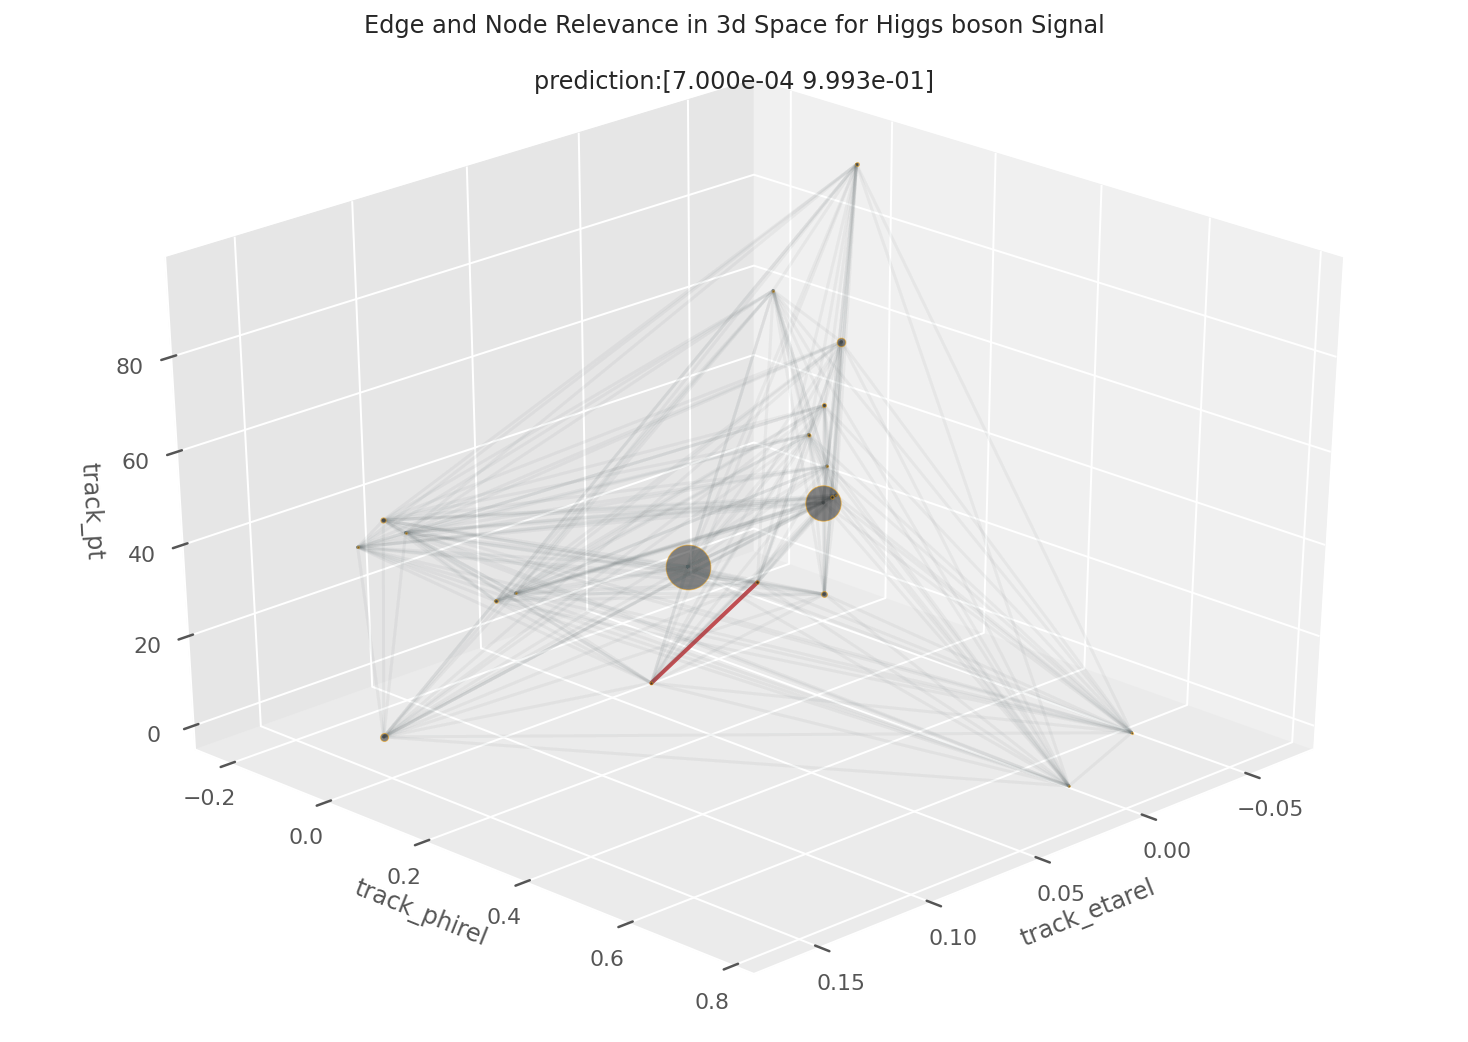

batch 3, jet 162


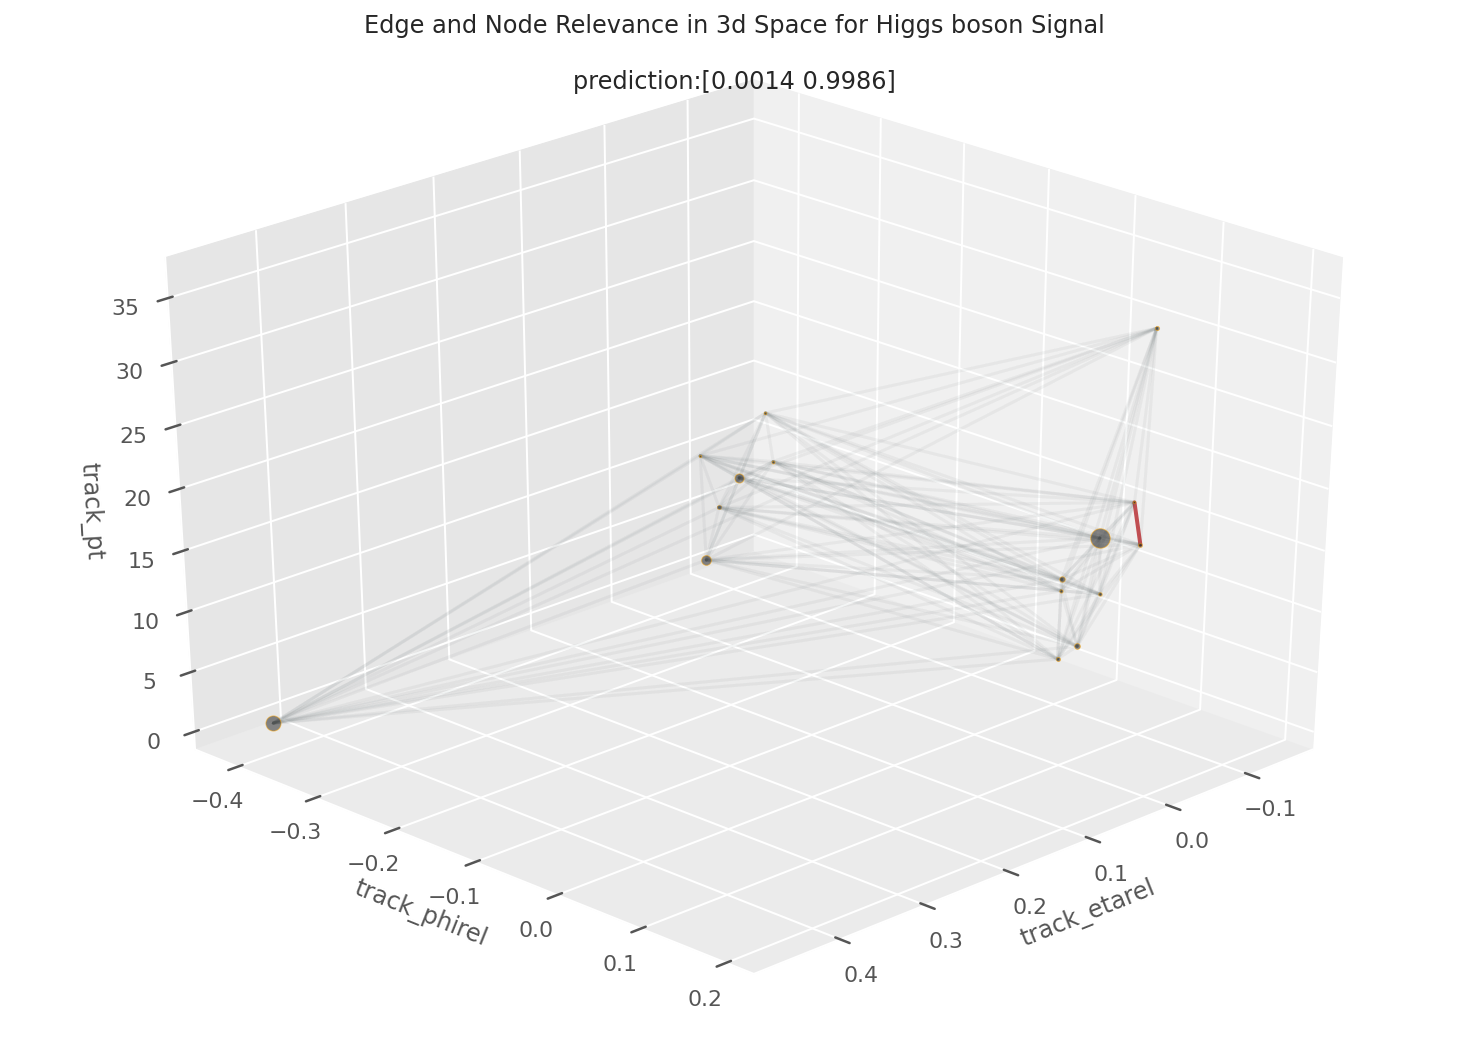

batch 3, jet 318


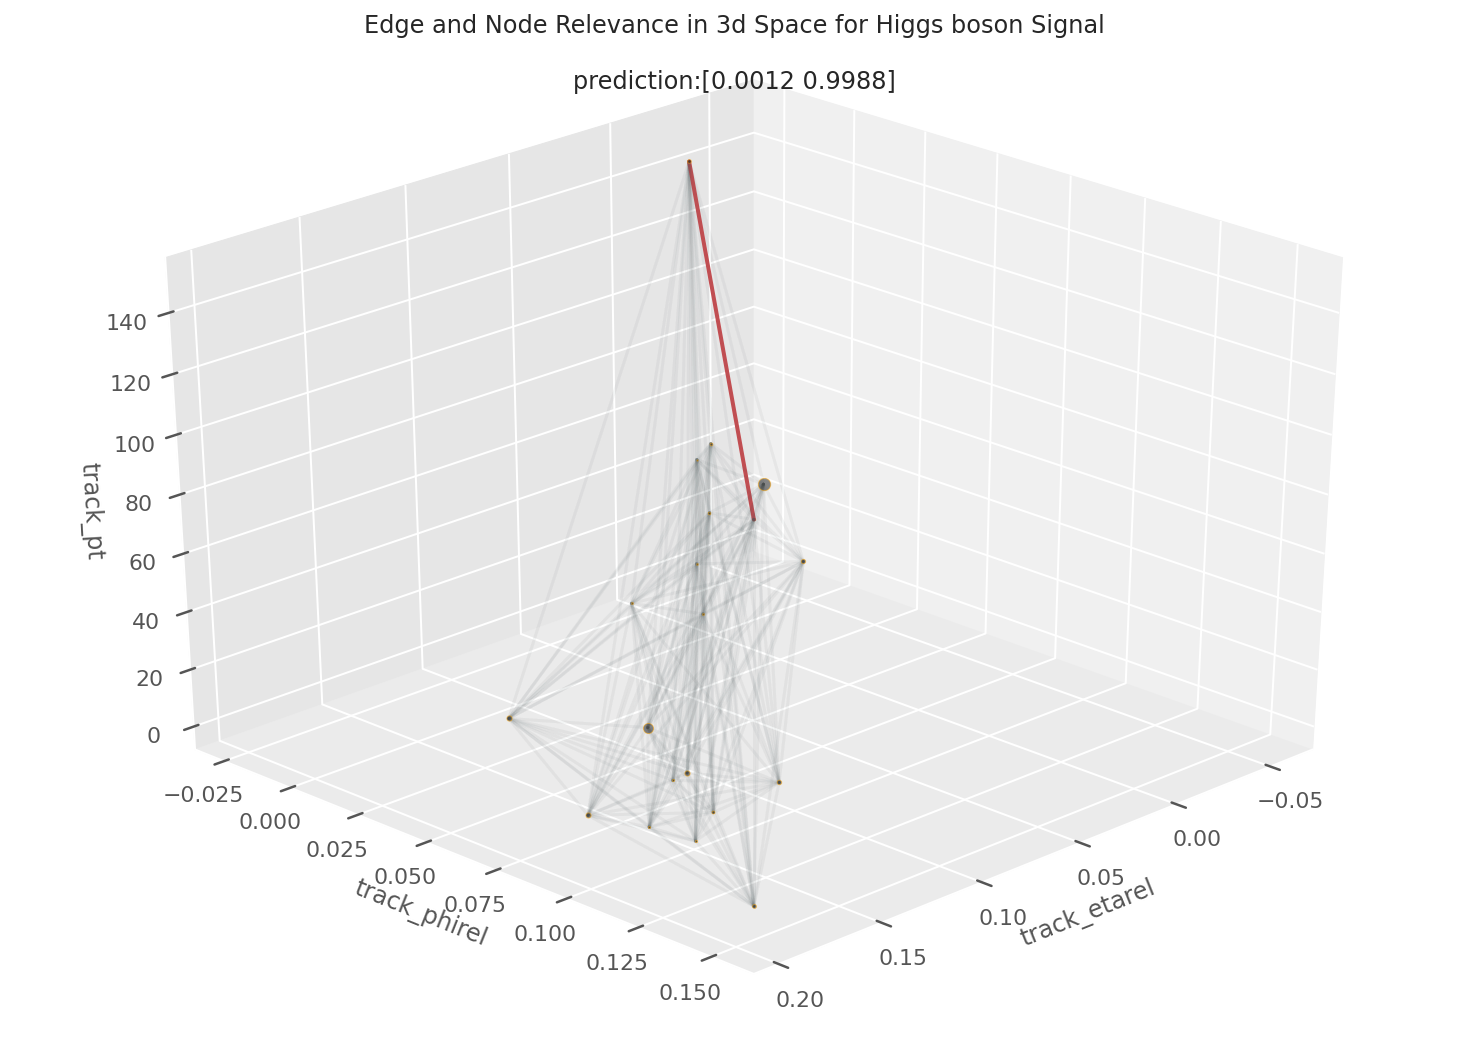

batch 3, jet 443


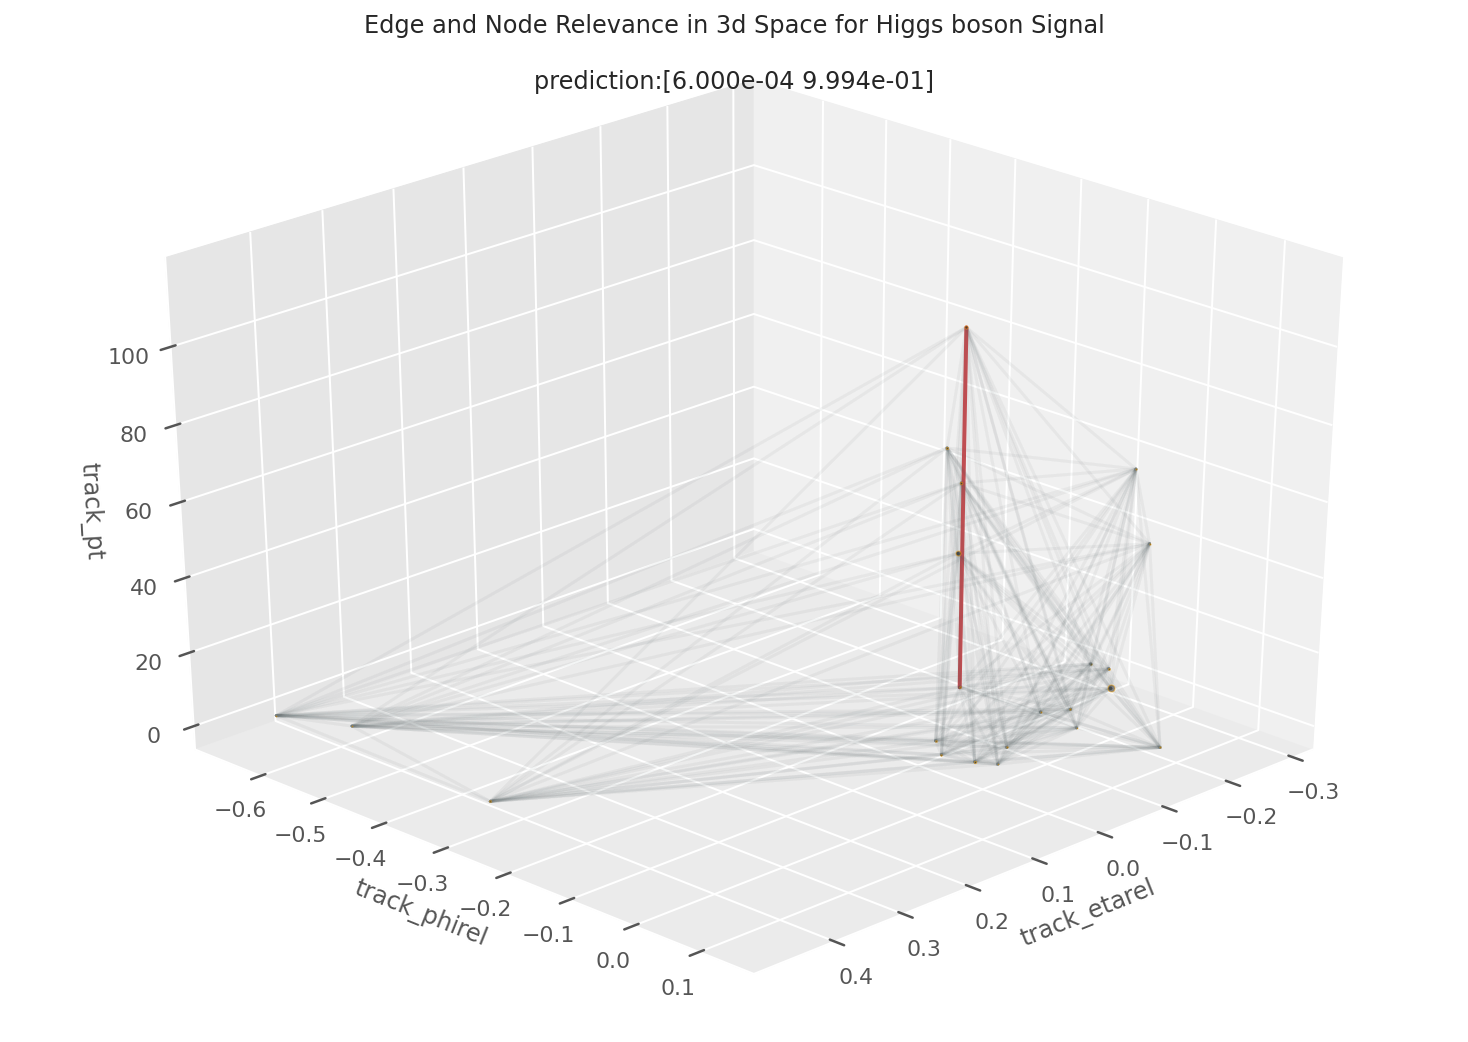

batch 3, jet 915


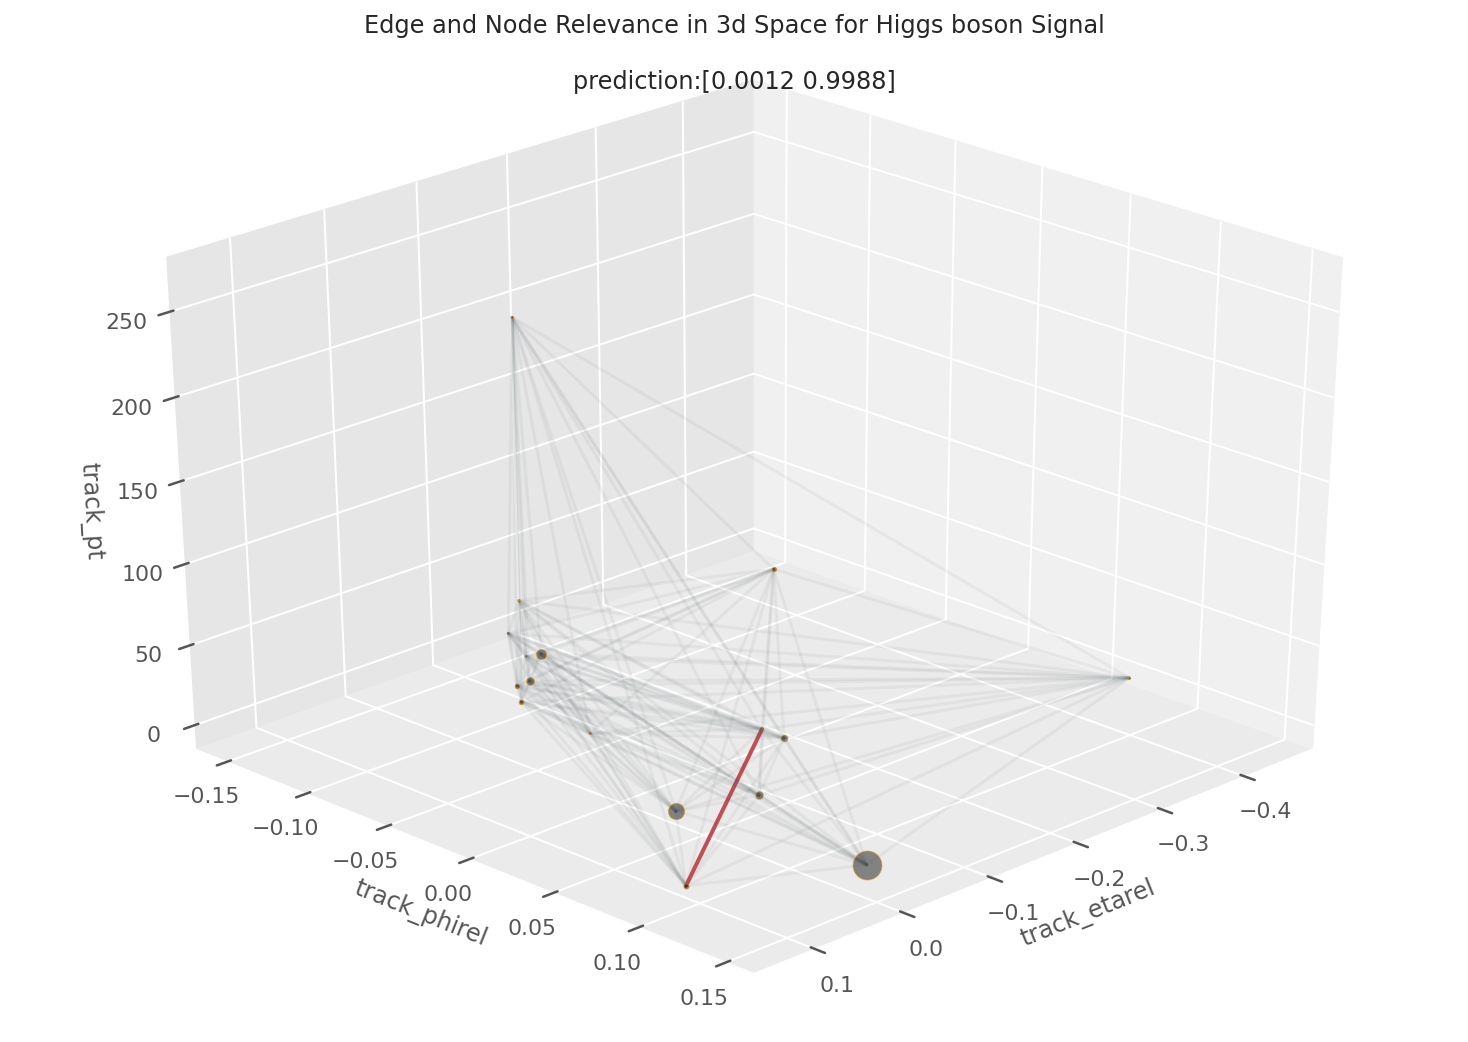

batch 4, jet 866


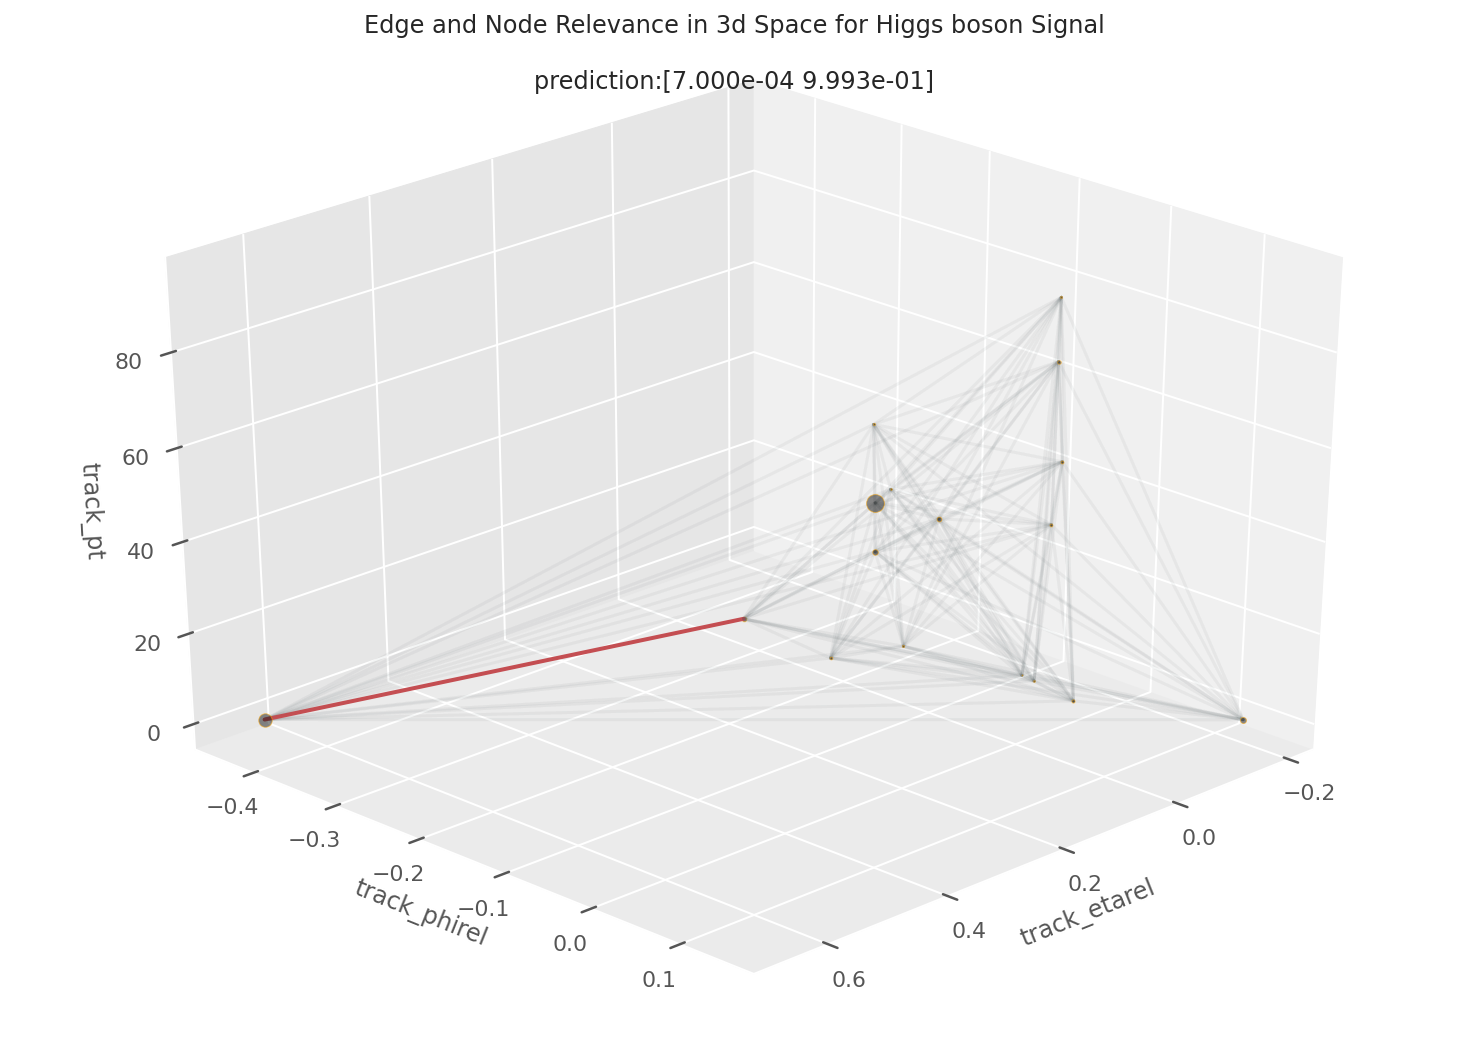

batch 5, jet 589


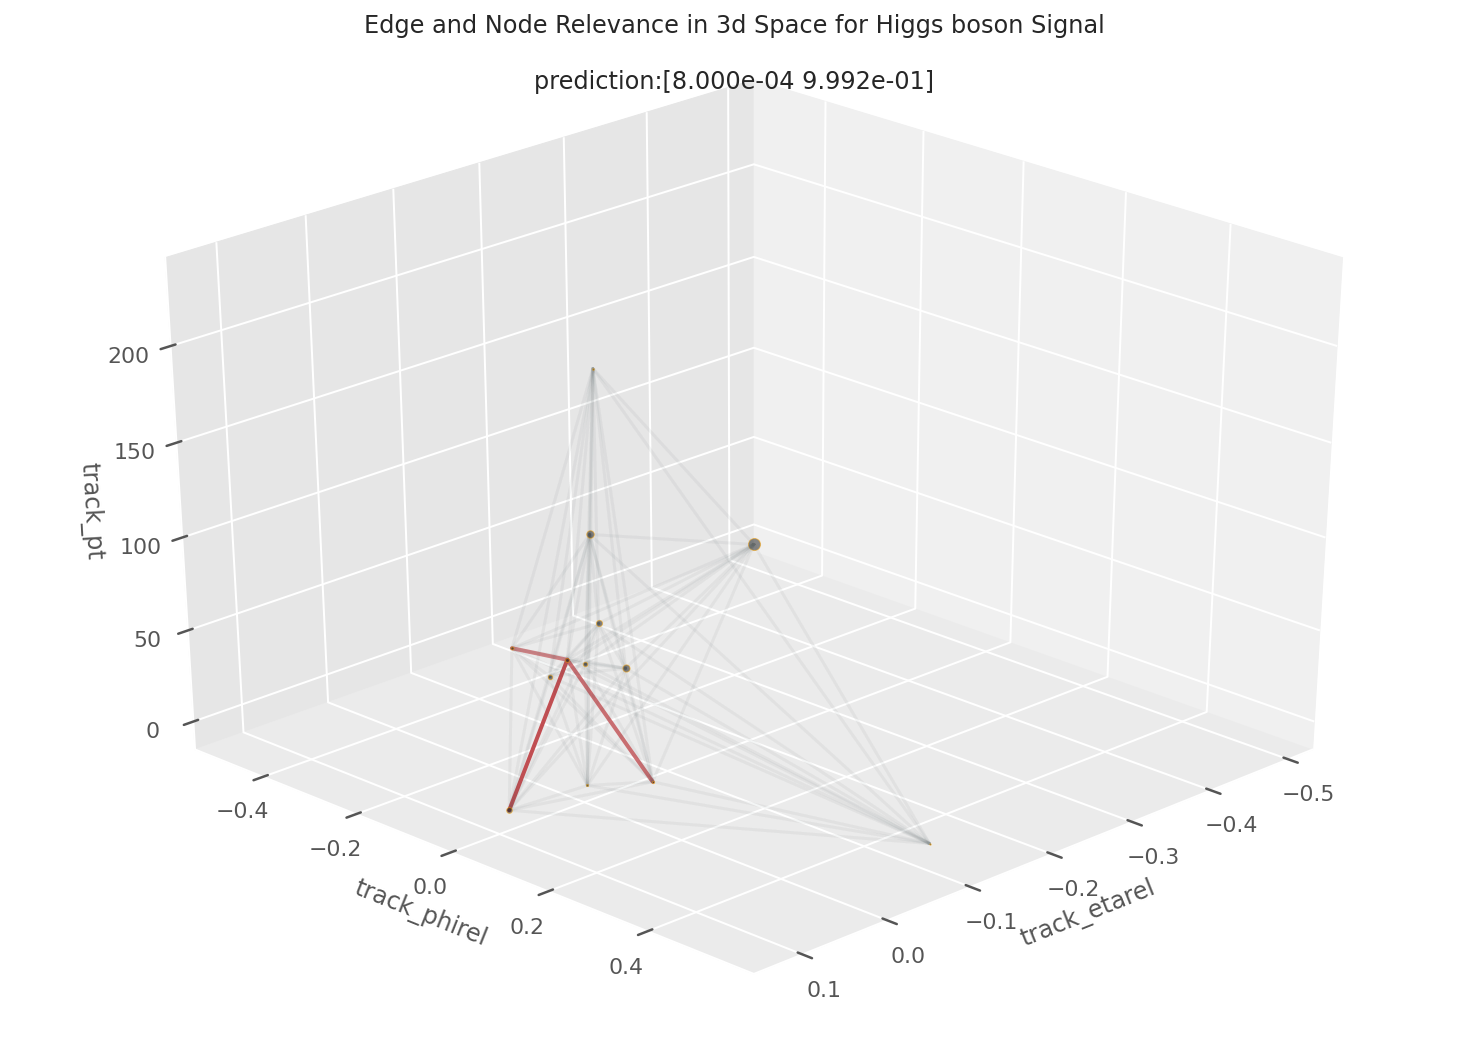

batch 6, jet 890


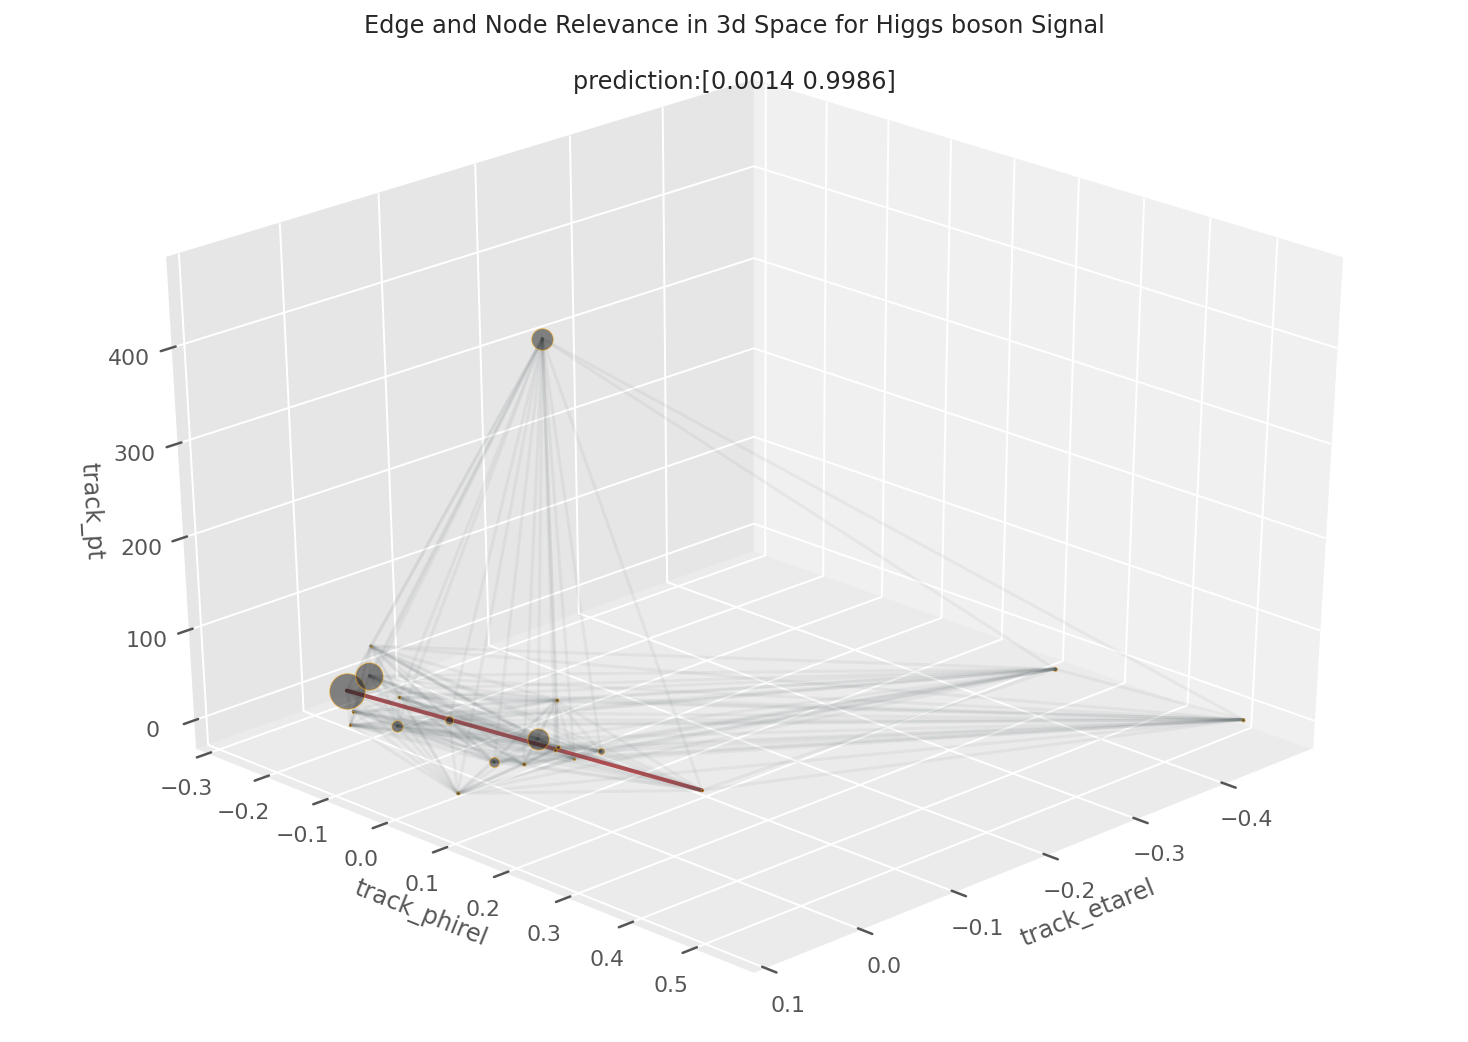

batch 9, jet 257


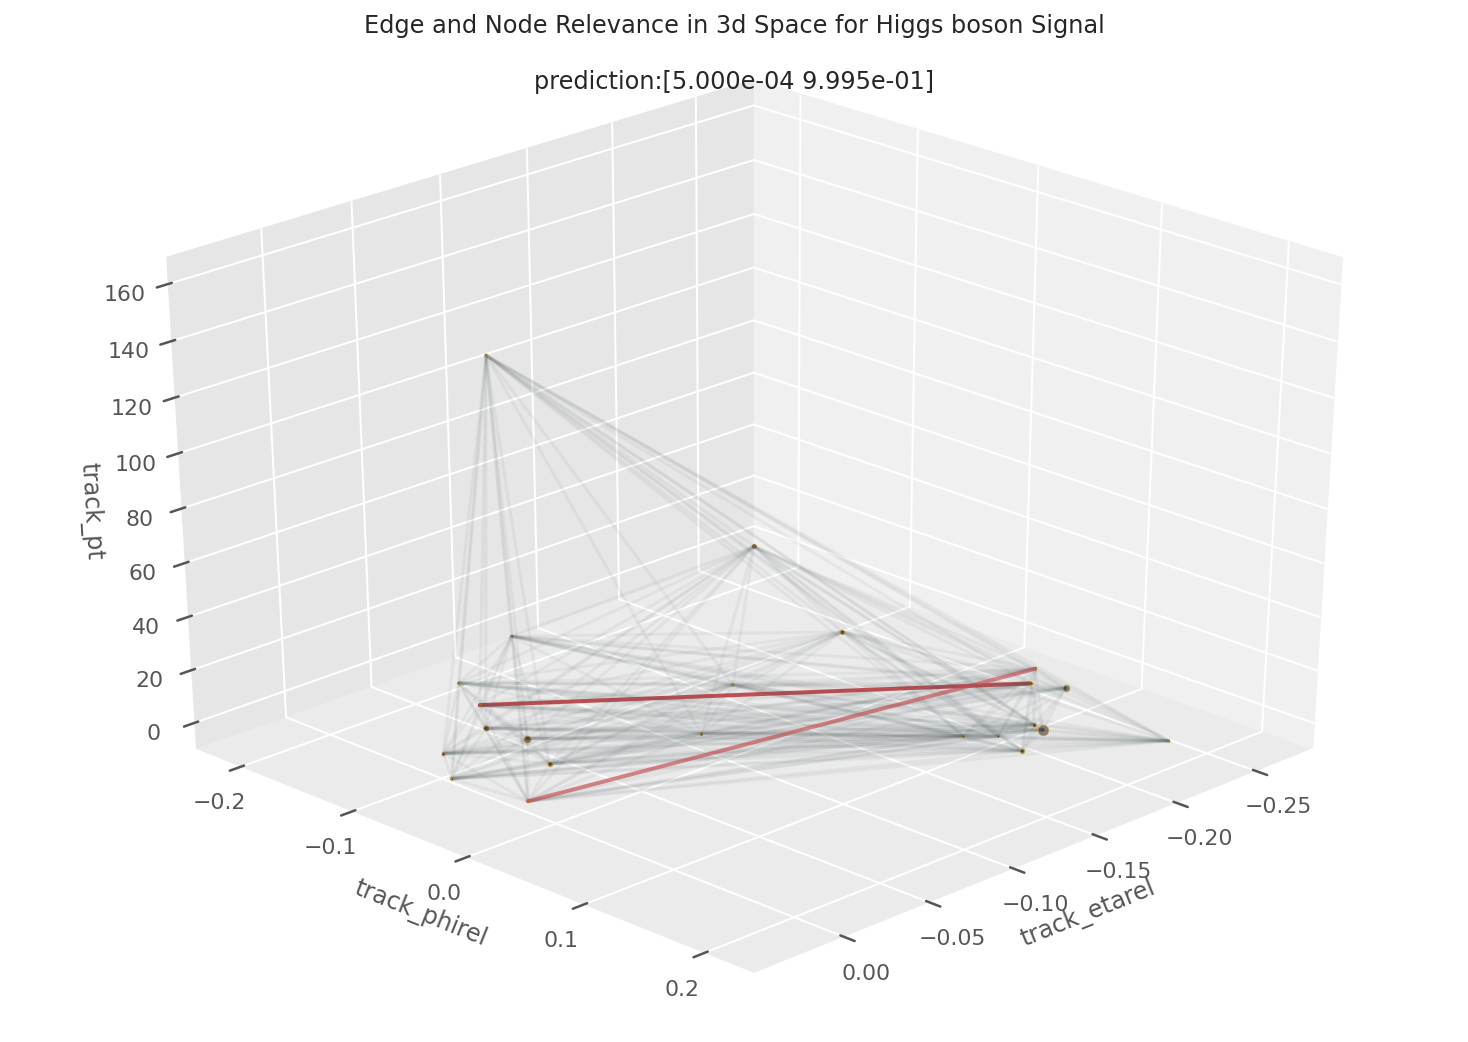

In [210]:
z="track_pt"

for ix,bix in zip(ix_list,bix_list):
    R=relevance_collection[bix][ix]
    raw_input=graph_dataset[bix][ix]
    
    print(f"batch {bix}, jet {ix}")
    plot_edge3d(R,ix,raw_input,features,x,y,z)